# micrograd

Following a [tutorial from Andrej Karpathy](https://youtu.be/VMj-3S1tku0?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

Implementing backpropagation (gradient descent) from scratch

In [27]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## What is a derivative
The derivative is how much a function `f()` respond to changes in `x`

We can also think about it as how does the slope looks like at a given point

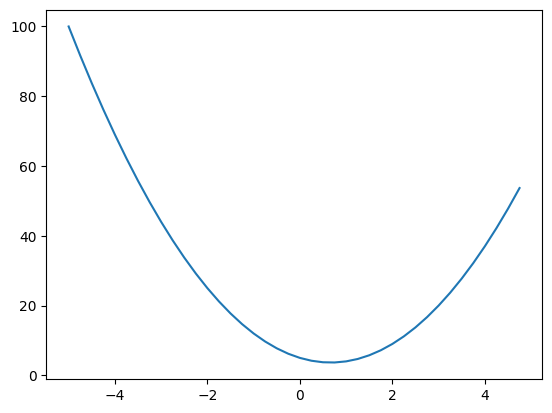

In [2]:
def f(x):
  return 3 * x**2 - 4 * x + 5

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [3]:
h = 0.00000001
x = 3.0
print(f'slope at {x=} is {(f(x + h) - f(x)) / h}')

slope at x=3.0 is 14.00000009255109


## Automate the derivative

The goal of micrograd is to wrap primitive math operations to automate the computation of the derivatives

In [4]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self * other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
    out = Value(self.data ** other, (self, ), f'**{other}')
    
    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other ** -1
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    x = self.data
    # taken from wikipedia
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1.0
    for node in topo[::-1]:
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

### tool to visualise the graph

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label=f'{{ {n.label} | {n.data:.4f} | grad {n.grad:.4f} }}', shape='record')
    if n._op:
      # if this value is the result of some operation, create an op node for it
      dot.node(name=uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

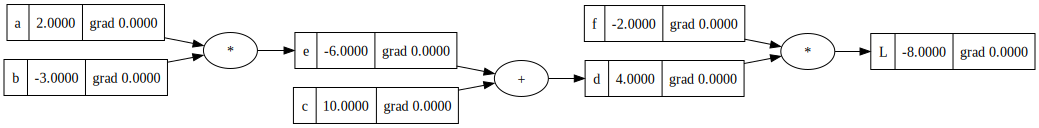

In [6]:
draw_dot(L)

## Computing devirative by hand
We are going to compute for every value, what is the derivative of L with respect to that node, for e.g
- dL/dL = 1.0; The derivative of L with respect to L is 1 (if we change the value of `L` by `h`, then `L` change by `h`)
- dL/da = 6.0; The derivative of L with respect to a is 6 (if we change the value of `a` by `h`, then `L` change by `6 * h`) # see example bellow in the `numerical_derivative_of_a()`
- ...
- dL/dd = -2.0; The derivative of L with respect to d is -2 (if we change the value of `d` by `h`, then `L` change by `-2 * h`)

### Numerical derivative
example in `numerical_derivative_of_a()`

### Symbolic derivative
```
given: L = d * f
dL/dd = f

because:
(f(x + h) - f(x)) / h
((d + h) * f - d * f) / h
(d * f + h * f - d * f) / h
(h * f) / h
f
```

#### Symbolic derivative: chain rule
see the [wikipedia article](https://en.wikipedia.org/wiki/Chain_rule)
> "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

dz/dx = dz/dy * dy/dx

#### Applied to our specific graph
```
WE WANT:
 dL/dc

WE KNOW:
 dL/dd
 dd/dc

SO:
 dL/dc = dL/dd * dd/dc
       = -2.0 * 1.0
       = -2.0
```

In [7]:
def numerical_derivative_of_a():
  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  a = Value(2.0 + h, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L2 = L.data

  print((L2 - L1) / h)

numerical_derivative_of_a()

6.000000000128124


## Using the derivative
Once we know the gradient for a node we can nudge the value in the direction of the gradient to influence L

```python
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
...
d.data += 0.01 * h.grad
```

## Simulate a Neuron
Neurons are a node with several inputs. Each input is multiplied by its own weight. The results are summed. We add a biais to the sum (a value owned by said neuron). And normalize the result by using an activation function, a common choice for the activation function is `tanh`. It normalize the values between -1 and 1.

Neuron output = $tanh(\sum_{i} w_i z_i + b)$

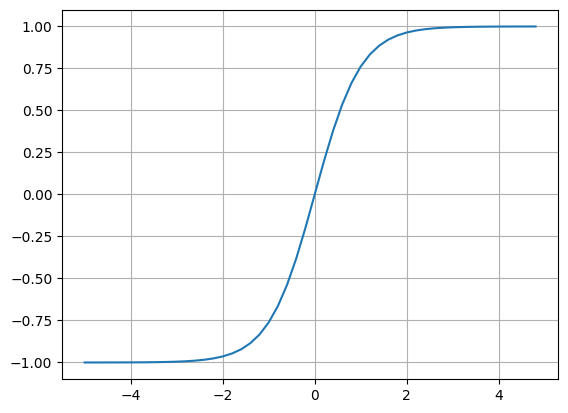

In [8]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [9]:
# make a neuron with 2 inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# biais of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

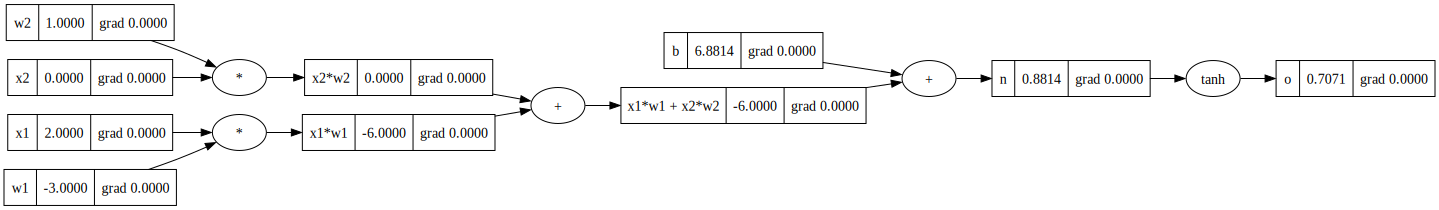

In [10]:
draw_dot(o)

### Compute the gradient (derivatives) manually

In [11]:
def manual_gradient():
  # the derivative with respect to itself is always 1.0
  o.grad = 1.0
  # the derivative of tanh is 1 - tanh^2 x
  n.grad = 1 - o.data ** 2
  # derivative of a sum just distribute the value between the term of the sum
  x1w1x2w2.grad = n.grad
  b.grad = n.grad
  # same
  x1w1.grad = x1w1x2w2.grad
  x2w2.grad = x1w1x2w2.grad
  # derivative of multiplication
  x1.grad = w1.data * x1w1.grad
  w1.grad = x1.data * x1w1.grad
  x2.grad = w2.data * x2w2.grad
  w2.grad = x2.data * x2w2.grad

# manual_gradient()

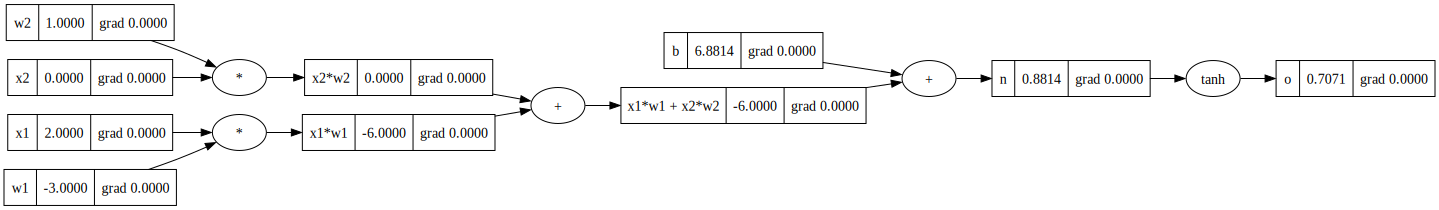

In [12]:
draw_dot(o)

### Compute the gradient (derivatives) semi-automatically
Using the `self._backward()` functions implemented for each supported primitives

In [13]:
def semi_auto():
  o.grad = 1.0
  o._backward()
  n._backward()
  x1w1x2w2._backward()
  x1w1._backward()
  x2w2._backward()
  # calling ._backward() on x1, x2, w1, w2, and b is a NOP

# semi_auto()

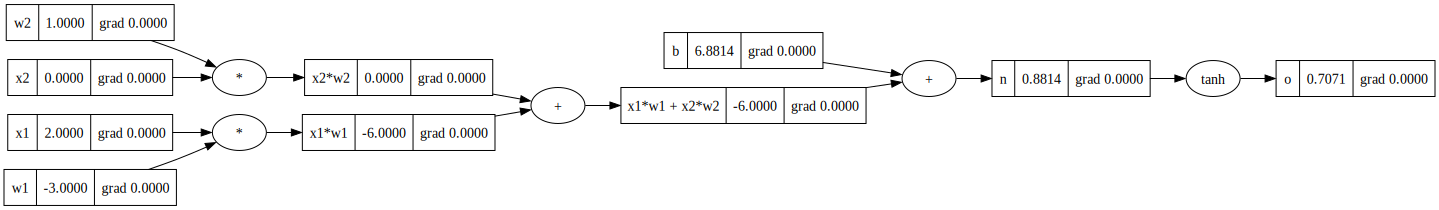

In [14]:
draw_dot(o)

### Compute the gradient (derivatives) automatically
By building a topological sort of the graph and calling on it`._backward()`

In [15]:
def auto():
  o.grad = 1.0
  
  topo = []
  visited = set()
  def build_topo(v):
    if v not in visited:
      visited.add(v)
      for child in v._prev:
        build_topo(child)
      topo.append(v)
  build_topo(o)
  
  for node in topo[::-1]:
    node._backward()

# auto()

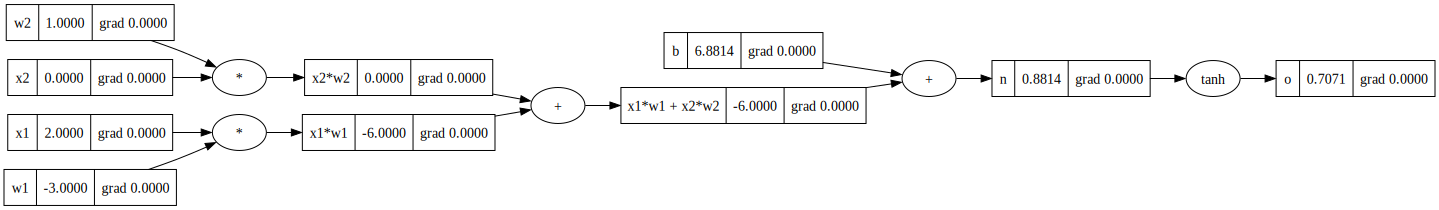

In [16]:
draw_dot(o)

### Compute the gradient (derivatives) automatically from the neuron object
By calling the `.backward()`

In [17]:
o.backward()

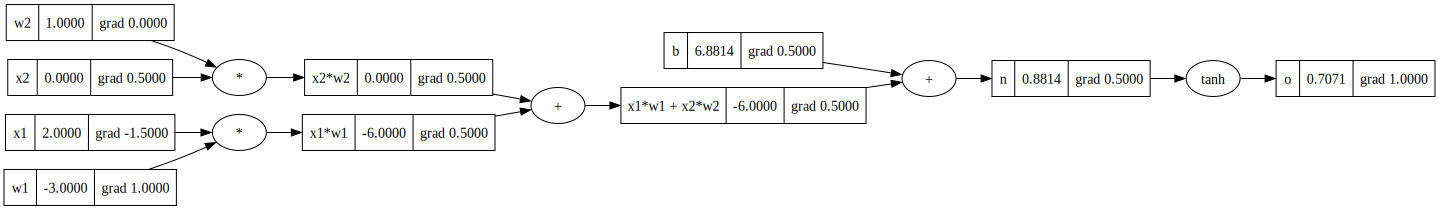

In [18]:
draw_dot(o)

### PyTorch equivalent
Take a look at the similar neuron example running in PyTorch.

In [23]:
import torch

# here the code is a bit akward because it's meant to work on tensor, and we aren't usually interrested in the intermediate grad
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


## Rounding off some corners
We want to support operations between a `Value()` and a `primitive` as well as `primitive` and `Value()` so we default cast `other` if needed, and implement `__radd__` and `__rmul__`.

In [20]:
# we expect to have no exceptions raised here
a = Value(2.0, label='a')
a + 1
a * 2
3 + a
4 * a

Value(data=8.0)

We also want to support `exp()`, `substractions`, and `divisions`.

For our case we are going to implement division as the multiplication of the inverse:
${a / b} = {a * b^{-1}}$

In [21]:
# we expect to have no exceptions raised here
a = Value(8.0, label='a')
a.exp()
b = Value(4.0, label='b')
a - b
a / b

Value(data=2.0)

Make sure the backward derivatives work by implementing a tanh in term of `exp`, `division`, and `substractions`.

$tanh(x) = {{e^{2x} - 1} \over {e^{2x} + 1}}$

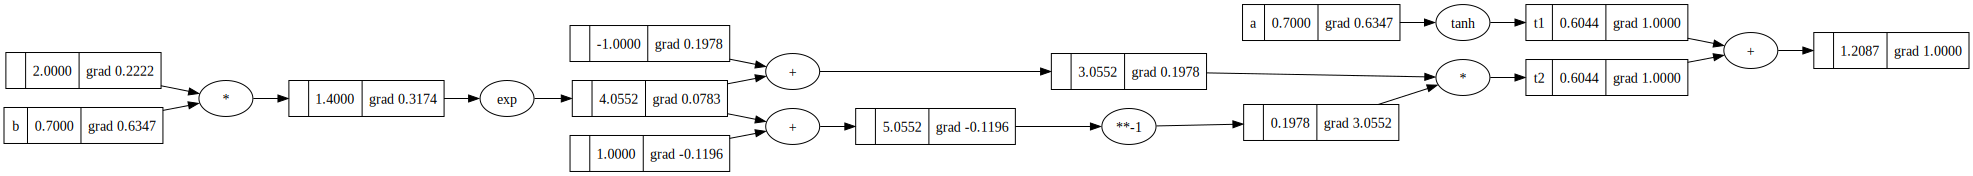

In [22]:
def tanh2(x):
  e = (2 * x).exp()
  return (e - 1) / (e + 1)

# we expect both `a` and `b` to have the same gradient
a = Value(0.7, label='a')
t1 = a.tanh(); t1.label = 't1'
b = Value(0.7, label='b')
t2 = tanh2(b); t2.label = 't2'
o = t1 + t2
o.backward()
draw_dot(o)

## Neural Network based on our Neuron

In [141]:
class Neuron:
  def __init__(self, nin): # nin = number of inputs
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi * xi  for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  '''Multi Layer Perceptron'''
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [142]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8308651726329422)

### Train our MLP on 4 datapoints
`xs` are input vectors

`ys` are desired values

In [143]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

#### Training loop
- Compute the squared error loss in a forward pass
- //!\\\\\\ Reset the previous gradients to 0.0
- Do a backward pass to compute gradients
- Update the weights based on the gradient
- ???
- profit (see your loss going down hopefully)

In [149]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout, in zip(ys, ypred)])

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 0.005610215011986809
1 0.005548904731843718
2 0.005488886144627541
3 0.005430119352207502
4 0.00537256607055815
5 0.0053161895493758285
6 0.005260954496433233
7 0.005206827006350022
8 0.0051537744934827216
9 0.005101765628659488
10 0.0050507702795056925
11 0.005000759454125852
12 0.004951705247923996
13 0.004903580793361213
14 0.004856360212463139
15 0.004810018571903919
16 0.00476453184050581
17 0.004719876849004221
18 0.004676031251939141
19 0.004632973491543497
